In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pyarrow as pa
import pyarrow.parquet as pq

df = pd.read_csv("C:/guided_proj_3/troop_movements.csv", index_col=False)

df2 = df.groupby(['empire_or_resistance']).size()

info = [['empire',df2[0]], ['resistance',df2[1]]]
empireResistanceDf = pd.DataFrame(info, columns = ['empire_or_resistance', 'count'])
empireResistanceDf


,empire_or_resistance,count
0,empire,656
1,resistance,344


In [2]:
df2 = df.groupby(['homeworld'])['homeworld'].count()
df2 = df2.to_frame()
df2 = df2.rename(columns={"homeworld": "Homeworld", "homeworld":"count"})
df2 = df2.reset_index()
df2

,homeworld,count
0,Alderaan,27
1,Aleen Minor,32
2,Bestine IV,34
3,Cerea,31
4,Champala,24
5,Chandrila,24
6,Concord Dawn,23
7,Corellia,25
8,Dagobah,18
9,Dathomir,28


In [3]:
df2 = df.groupby(['unit_type'])['unit_type'].count()
df2 = df2.to_frame()
df2 = df2.rename(columns={"unit_type": "Unit_type", "unit_type":"count"})
df2 = df2.reset_index()
df2

,unit_type,count
0,at-at,151
1,at-st,117
2,resistance_soldier,113
3,stormtrooper,140
4,tie_fighter,127
5,tie_silencer,121
6,unknown,104
7,x-wing,127


In [4]:
df['is_resistance'] = np.where(df['empire_or_resistance'] == 'resistance', 'True', 'False')
df

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2023-07-12 10:49:49,1,tie_fighter,empire,10,2,3,4,Aleen Minor,False
1,2023-07-12 10:49:48,2,at-st,empire,10,8,6,6,Stewjon,False
2,2023-07-12 10:49:47,3,tie_silencer,empire,10,4,2,5,Mirial,False
3,2023-07-12 10:49:46,4,at-at,empire,3,9,8,10,Bestine IV,False
4,2023-07-12 10:49:45,5,tie_fighter,empire,7,6,5,6,Naboo,False
...,...,...,...,...,...,...,...,...,...,...
995,2023-07-12 10:33:14,996,tie_silencer,empire,3,10,5,4,Trandosha,False
996,2023-07-12 10:33:13,997,at-st,empire,9,2,5,8,Ryloth,False
997,2023-07-12 10:33:12,998,at-st,empire,2,6,4,6,Umbara,False
998,2023-07-12 10:33:11,999,resistance_soldier,resistance,7,3,3,5,Umbara,True


<Axes: xlabel='empire_or_resistance', ylabel='count'>

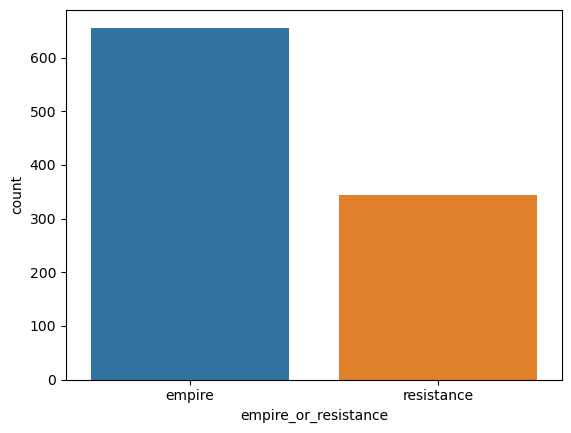

In [5]:
sns.barplot(data=empireResistanceDf, x="empire_or_resistance", y="count")

In [6]:
# df_dummies = pd.get_dummies(df.homeworld, df.unit_type)
df_dummies = pd.get_dummies(data=df[['homeworld', 'unit_type']], columns=['homeworld', 'unit_type'])
#print(list(df_dummies.columns))
#print(df_dummies)
X = df_dummies
y = df['is_resistance']

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 1.0


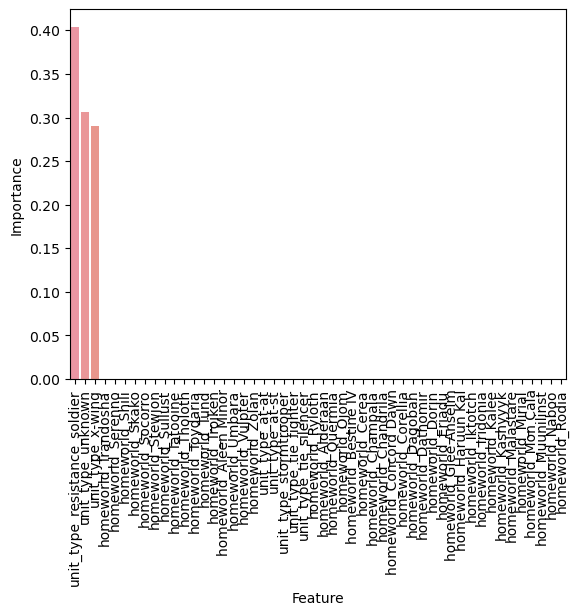

In [7]:
# Get feature importances
importances = clf.feature_importances_


# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': df_dummies.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

#feature_importances
barPlot = sns.barplot(data=feature_importances, x="Feature", y="Importance")
for item in barPlot.get_xticklabels():
    item.set_rotation(90)


In [8]:
filename = 'trained_model.pkl'
with open (filename, 'wb') as file:
    pickle.dump(clf,file)


In [9]:
df_troop_10m = pd.read_csv("C:/guided_proj_3/troop_movements10m.csv", index_col = False)

df_troop_10m['unit_type'] = np.where(df_troop_10m['unit_type'] == 'invalid_unit', 'unknown', df_troop_10m['unit_type'])
df_troop_10m['unit_type'] = np.where(df_troop_10m['unit_type'] == 'tauntaun', 'unknown', df_troop_10m['unit_type'])


In [10]:
df_troop_10m['location_x'].ffill(inplace = True)
df_troop_10m['location_y'].ffill(inplace = True)

In [11]:
parquet_file = 'troop_movements10m.parquet'
df_troop_10m.to_parquet(parquet_file, engine = 'pyarrow')

In [12]:
with open(filename, 'rb') as file:
    model2 = pickle.load(file)

test_data = pd.read_parquet(parquet_file)
df_model = pd.get_dummies(test_data[['homeworld', 'unit_type']])
#df_model = pd.DataFrame(test_data, columns=[['homeworld'],['unit_type'])
predictions = model2.predict(df_model)
print(predictions)

['False' 'False' 'False' ... 'False' 'False' 'True']


In [13]:
test_data['predictions'] = predictions
test_data.head()

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld,predictions
0,2023-06-13 17:33:18,1,at-st,2.0,8.0,1,1,Glee Anselm,False
1,2023-06-13 17:33:17,2,tie_silencer,4.0,4.0,0,1,Trandosha,False
2,2023-06-13 17:33:16,3,at-at,0.0,3.0,6,1,Corellia,False
3,2023-06-13 17:33:15,4,tie_silencer,6.0,1.0,6,9,Shili,False
4,2023-06-13 17:33:14,5,tie_fighter,0.0,4.0,9,6,Muunilinst,False
